In [1]:
import librosa  # for audio processing
import librosa.display

import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile  # for audio processing
from numpy.lib.stride_tricks import as_strided
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import wavfile as wav
import sklearn
import pandas as pd
from os.path import exists
import sys
import os

import warnings
warnings.filterwarnings("ignore")

In [52]:
# importing local script
sys.path.append(os.path.abspath(os.path.join('../scripts/')))


In [68]:
amharic_train ='../../data/train/'
amharic_train_wav = os.path.join(amharic_train, 'wav')




In [69]:
%cd C:/Users/dan/Documents/10 Academy/Week 4/Speech-to-Text/data/train

C:\Users\dan\Documents\10 Academy\Week 4\Speech-to-Text\data\train


In [71]:
train_fail_names = os.listdir(amharic_train_wav)
train_wav_paths =[os.path.join(amharic_train_wav, file_name)
                for file_name in train_fail_names]
print(f"We have {len(train_wav_paths)} Amharic wav files in the training set")

We have 10875 Amharic wav files in the training set


In [74]:
x, sr = librosa.load(train_wav_paths[0])
print(f"audio shape: {x.shape} sampling rate: {sr}")

audio shape: (200391,) sampling rate: 22050


In [77]:
ipd.Audio(train_wav_paths[0])

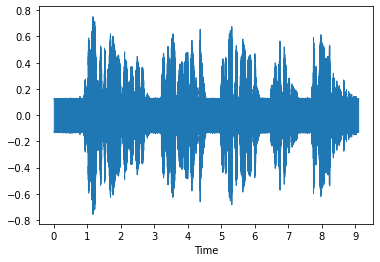

In [81]:
librosa.display.waveshow(x,sr=sr)

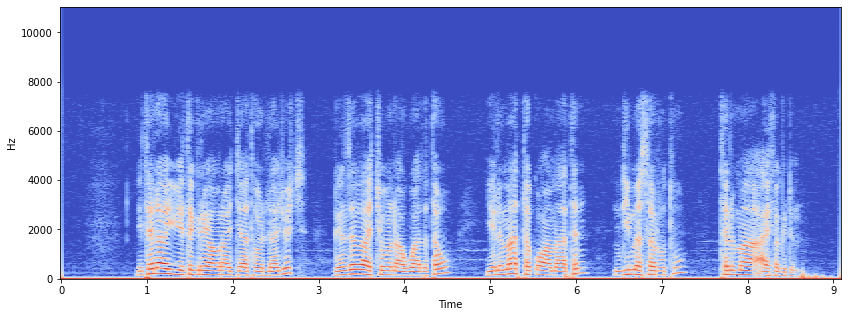

In [85]:
X = librosa.stft(x)
Xdb= librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb,sr=sr,x_axis='time', y_axis='hz')

(150000,)


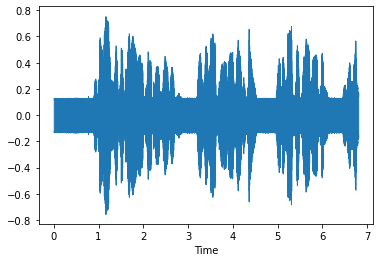

In [93]:
length_fixed = librosa.util.fix_length(x,size=150000)
print(length_fixed.shape)
librosa.display.waveshow(length_fixed,sr=sr)
ipd.Audio(data=length_fixed, rate=sr)


## Mono to Sterio

In [111]:
import numpy as np
def conver_to_sterio(audio: np.array) -> np.array:
    if len(audio.shape)==1:
        sterio =np.stack([audio, audio], axis =1)
    
        return sterio
    return audio
        

In [112]:
x, sr = librosa.load(train_wav_paths[0], mono=False)
sterio = conver_to_sterio(x)

In [113]:
sterio.shape, x.shape

((200391, 2), (200391,))

In [116]:
wavfile.write('sterio.wav',sr,sterio)


In [117]:
ipd.Audio(train_wav_paths[0])

In [118]:
ipd.Audio('sterio.wav')

### Plot of the Audio Array

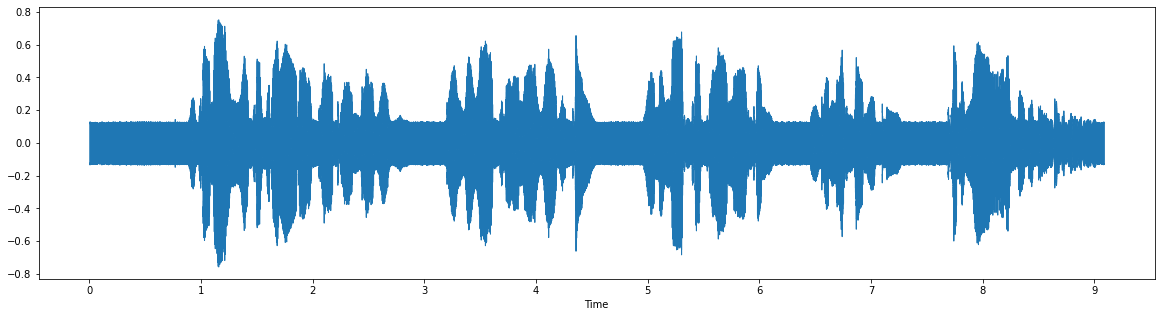

In [163]:
plt.figure(figsize=(20,5))
librosa.display.waveshow(x, sr = sr)

## Data Augmentation


In [164]:
class AugmentAudio:
    def __init__(self) -> None:
        pass

    def add_noise(self, data: np.array, noise_factor: float) -> np.array:
        noise = np.random.randn(len(data))
        augmented_data = data + noise_factor * noise
        augmented_data = augmented_data.astype(type(data[0]))

        return augmented_data

    def add_time_shift(self,
                       data: np.array,
                       sampling_rate: int,
                       shift_max: float,
                       shift_direction: str) -> np.array:
        shift = np.random.randint(sampling_rate * shift_max)
        if shift_direction == 'right':
            shift = -shift
        elif shift_direction == 'both':
            direction = np.random.randint(0, 2)
            if direction == 1:
                shift = -shift
        augmented_data = np.roll(data, shift)
        if shift > 0:
            augmented_data[:shift] = 0
        else:
            augmented_data[shift:] = 0

        return augmented_data
    
    def change_pitch(self, data, sampling_rate, pitch_factor):
        return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

    def change_speed(self, data, speed_factor):
        return librosa.effects.time_stretch(data, speed_factor)
audio_augmenter = AugmentAudio()

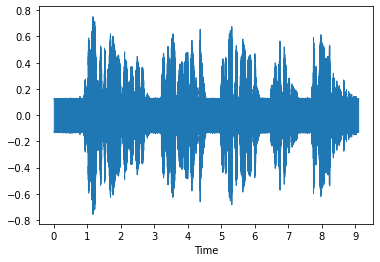

In [165]:
librosa.display.waveshow(x, sr=sr)
ipd.Audio(data=x, rate=sr)

## adding noise

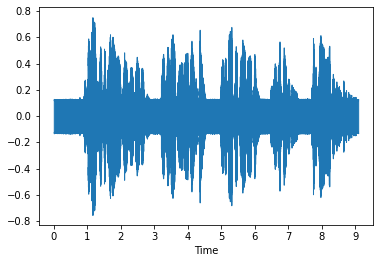

In [166]:
noise_added = audio_augmenter.add_noise(x, noise_factor=0.0001)
librosa.display.waveshow(noise_added, sr=sr)
ipd.Audio(data=noise_added, rate=sr)


## Adding same random shift

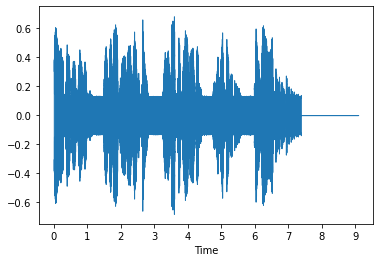

In [176]:
time_shifted= audio_augmenter.add_time_shift(x, sr, 5, 'both')
librosa.display.waveshow(time_shifted, sr=sr)
ipd.Audio(data=time_shifted, rate=sr)

### changing the pitch

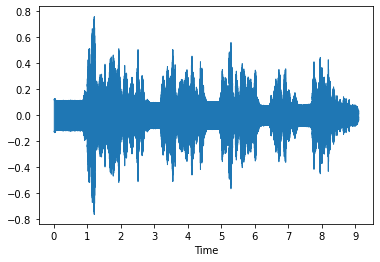

In [177]:
pitch_shifted = audio_augmenter.change_pitch(x,sr, pitch_factor=10)
librosa.display.waveshow(pitch_shifted, sr=sr)
ipd.Audio(data= pitch_shifted, rate=sr)

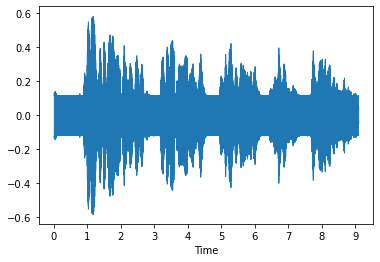

In [178]:
pitch_shifted = audio_augmenter.change_pitch(x,sr, pitch_factor=0.1)
librosa.display.waveshow(pitch_shifted, sr=sr)
ipd.Audio(data= pitch_shifted, rate=sr)

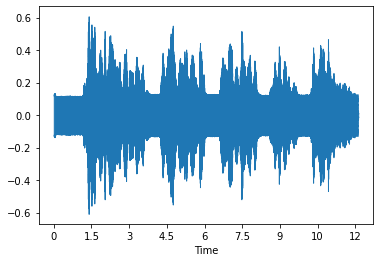

In [179]:
speed_changed = audio_augmenter.change_speed(x, speed_factor=0.75)
librosa.display.waveshow(speed_changed, sr=sr)
ipd.Audio(data= speed_changed, rate=sr)

### Feature Extraction from audio

(20, 392)


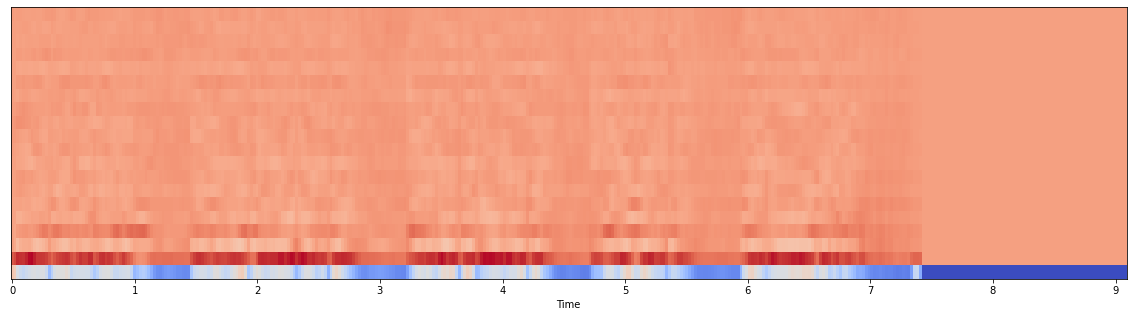

In [183]:
plt.figure(figsize=(20,5))
mfccs = librosa.feature.mfcc(time_shifted, sr =sr)
librosa.display.specshow(mfccs, sr=sr , x_axis = 'time')
print(mfccs.shape)

### Transcription and Loading 

In [171]:
class DataLoader:

    # def __init__(self) -> None:
        # my_logger = App_Logger("../logs/henok_dat_loader.log")
        # self.logger = my_logger.get_app_logger()

    def transcription_loader(self, filename):
        name_to_text = {}
        with open(filename, encoding="utf-8") as f:
            for line in f:
                name = line.split("</s>")[1]
                name = name.replace('(', '')
                name = name.replace(')', '')
                name = name.replace('\n', '')
                name = name.replace(' ', '')
                text = line.split("</s>")[0]
                text = text.replace("<s>", "")
                name_to_text[name] = text
            # self.logger(f"audio-transcription pairs generated")
            return name_to_text

    def audio_metadata_generator(self, transcription, path):
        target = []
        features = []
        filenames = []
        duration_of_recordings = []
        for key in transcription:
            filename = path + key + ".wav"
            filenames.append(filename)
            audio, fs = librosa.load(filename, sr=None)
            duration_of_recordings.append(librosa.get_duration(y=audio, sr=fs))
            label = transcription[key]
            target.append(label)
        # self.logger(f"audio-metadata generated")
        return filenames, target, duration_of_recordings


In [172]:
data_loader = DataLoader()
name_to_text= data_loader.transcription_loader('../../data/train//trsTrain.txt')

In [173]:
meta_data= data_loader.audio_metadata_generator(name_to_text, '../../data/train/wav/')

In [174]:
meta_data_df = pd.DataFrame({
    "path": meta_data[0],
    "text": meta_data[1],
    "duration":meta_data[2]
})

In [175]:
meta_data_df.head()

path  \
0  ../../data/train/wav/tr_1_tr01001.wav   
1  ../../data/train/wav/tr_2_tr01002.wav   
2  ../../data/train/wav/tr_3_tr01003.wav   
3  ../../data/train/wav/tr_4_tr01004.wav   
4  ../../data/train/wav/tr_5_tr01005.wav   

                                                text  duration  
0                   ያንደኛ ደረጃ ትምህርታቸው ን ጐንደር ተ ም ረዋል      4.608  
1   የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስ...    16.384  
2   በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ...    14.592  
3                         ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው      4.736  
4   ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳ...     8.192

In [161]:
import json
meta_data_json = meta_data_df.to_dict(orient='records')
with open('train_corpus.json', 'w') as f:
    json.dump(meta_data_json, f, indent=2)